![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite.png)
# Isochrone Generation Example
Isochrones are a type of _iso line_—a contour that connects points sharing the same value. While contour lines link points of equal elevation and isotherms connect equal temperatures, isochrones outline regions that are reachable within a specific amount of travel time. They're commonly used to answer questions like: 'How far can I drive from here in 15 minutes?' or 'Which neighborhoods are within a 10-minute walk of a school?'

In this example we will generate `30` minute isochrones for all the fire stations in California in the bounding box between Bakersfield and Merced. Then we will left join the places overture table to those isochrones to label the high risk places that are >30 minutes from a fire station. Finally we will generate clusters with DBSCAN to determine if there are regions where a firestation might be useful

## Define Sedona Context

In [1]:
from sedona.spark import *
import pyspark.sql.functions as f
import os

config = SedonaContext.builder().getOrCreate()
sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Initialize Data

- For this analysis we're accessing the Overture Places dataset that is freely available in the Wherobots Spatial Catalog. 
- We apply a Spatial filter to pull the Overture places within a region of California. These are the locations for which we want to determine fire station proximity

In [3]:
%%time
polygon = "POLYGON ((-120.805664 35.32633, -118.861084 35.32633, -118.861084 37.378888, -120.805664 37.378888, -120.805664 35.32633))"

ca_places_df = sedona.table("wherobots_open_data.overture_2025_01_22_0.places_place")\
                .where(f"ST_Intersects(geometry, ST_GeomFromWKT('{polygon}'))")\
                .repartition(sedona.sparkContext.defaultParallelism * 2) # Havasu will only hit a few files; lets make sure our dataframe has enough partitions to utilize our cluster well.

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 1.55 s


## Generate the isochrones

Here we generate an isochrone for `30` minutes for all 1,857 fire stations in our dataframe.

There are 4 arguments for the `ST_Isochrone()` funcion:

1. `geometry`: The starting point from which we will generate the isochrone.
2. `time`: travel time in minutes; In our case `30`.
3. `mobility_type`: Transportation; In our case, `car`.
4. `inbound`: Indicates if the geometry is a destination (true) or origin (false); in our case the points represent the `origin`.

You'll notice this dataframe is marked for caching. Caching allows the database to plan the join efficiently without calculating the isochrones twice.

In the result below, you can see that the isochrones are returned as a list of polygons with the order matching the time limits. 

In [4]:
%%time
ca_places_df.createOrReplaceTempView("ca_places")

isochrones_df = sedona.sql(f'''
    SELECT *, ST_Isochrone(geometry, 30, 'car', false) AS isochrone
    FROM ca_places
    WHERE categories.primary = 'fire_department'
''').cache()

isochrones_df.count()

CPU times: user 38.3 ms, sys: 13.8 ms, total: 52.2 ms
Wall time: 52.3 s


111

#### Map the Results with Sedona Kepler

In [ ]:
SedonaKepler.create_map(isochrones_df.withColumn("geometry", f.col("isochrone")),name="Isochrones")

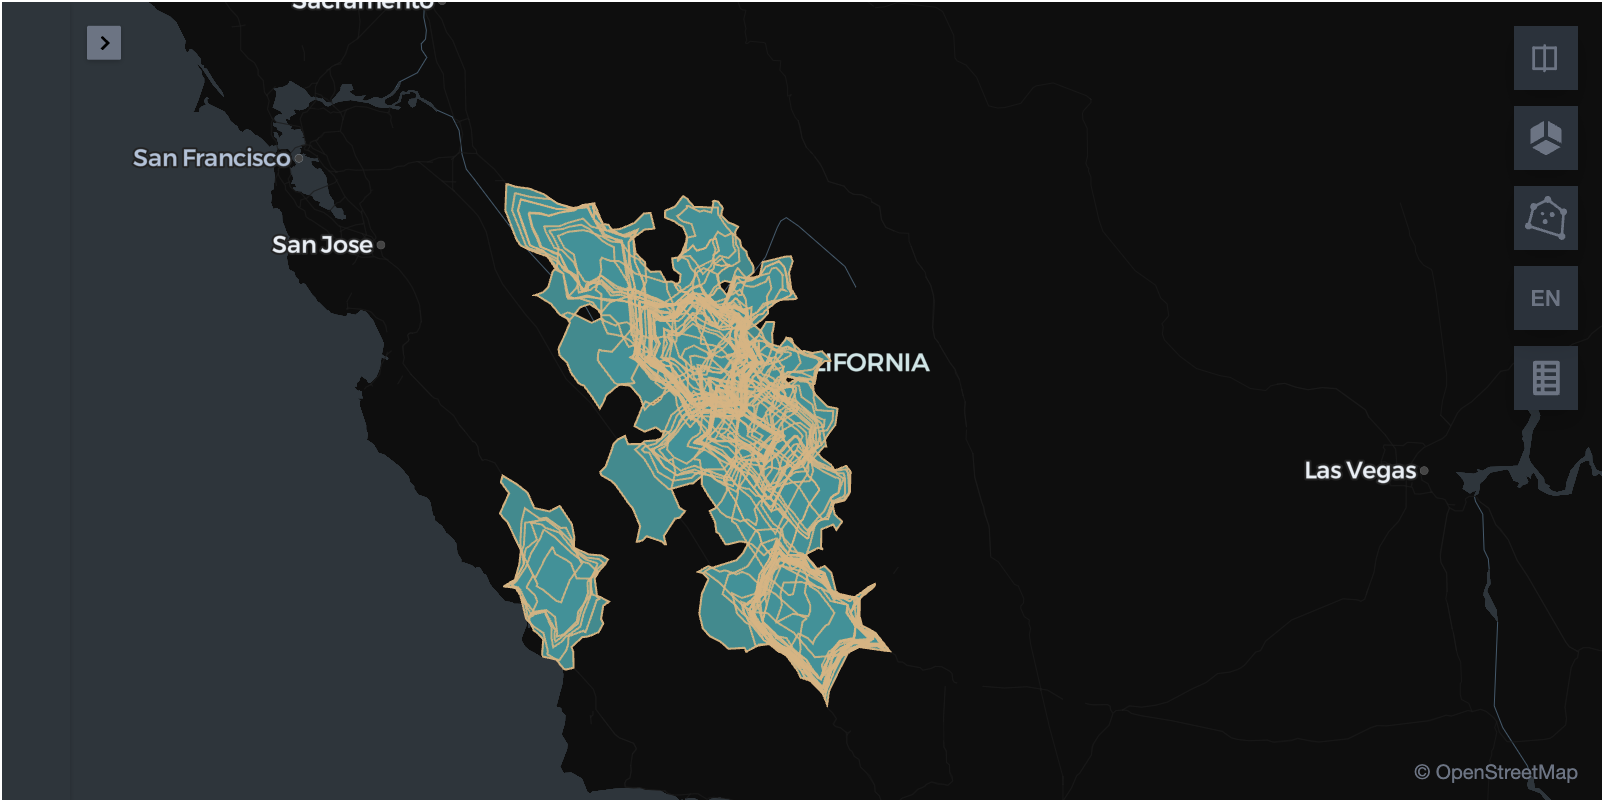

## Which Overture Places are outside the reach of any Fire Station?
This query identifies places from the Overture Maps Places dataset that do not fall within any fire station’s isochrone. We perform a left spatial join between the Places and the isochrones, then filter for records where no intersection is found. The result highlights all locations that lie outside the maximum coverage area (e.g., a 30-minute drive time) of any fire station — indicating areas that may be underserved or at higher response risk.

In [7]:
%%time
isochrones_df.createOrReplaceTempView("isochrones")

risk_df = sedona.sql(f'''
    SELECT ca_places.*, iso.isochrone
    FROM ca_places
    LEFT JOIN isochrones AS iso
      ON ST_Intersects(iso.isochrone, ca_places.geometry)
    WHERE iso.isochrone IS NULL
''')

risk_df.write.format("geoparquet").mode("overwrite").save(os.getenv("USER_S3_PATH") + "fireRiskExampleIsochrones")

CPU times: user 9.59 ms, sys: 4.92 ms, total: 14.5 ms
Wall time: 11.7 s


## Find Clusters of OMF Place *not* near Fire Stations
Finally, we use WherobotsDB's DBSCAN to find clusters of places that are not close to a fire station.

In [10]:
isochrones_df.unpersist()
risk_df = sedona.read.format("geoparquet").load(os.getenv("USER_S3_PATH") + "fireRiskExampleIsochrones")
risk_df.count()

514

In [11]:
%%time
risk_df.createOrReplaceTempView("risk")

clustered_high_risk_df = sedona.sql('''
    SELECT *, ST_DBSCAN(geometry, 10000.0, 25, true) AS dbscan_result
    FROM risk
''').cache()

clustered_high_risk_df.count()

CPU times: user 22.4 ms, sys: 5.61 ms, total: 28 ms
Wall time: 50.1 s


514

#### Map the Results with Sedona Kepler

In [13]:
%%time
clustered_high_risk_df.createOrReplaceTempView("clustered")

high_risk_polygons_df = sedona.sql('''
    SELECT dbscan_result.cluster, ST_ConvexHull(ST_Union_Aggr(geometry)) AS geometry
    FROM clustered
    WHERE dbscan_result.cluster != -1
    GROUP BY dbscan_result.cluster
''')

high_risk_polygons_df.count()

CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 231 ms


5

In [ ]:
%%time
SedonaKepler.create_map(high_risk_polygons_df, name="Clusters")

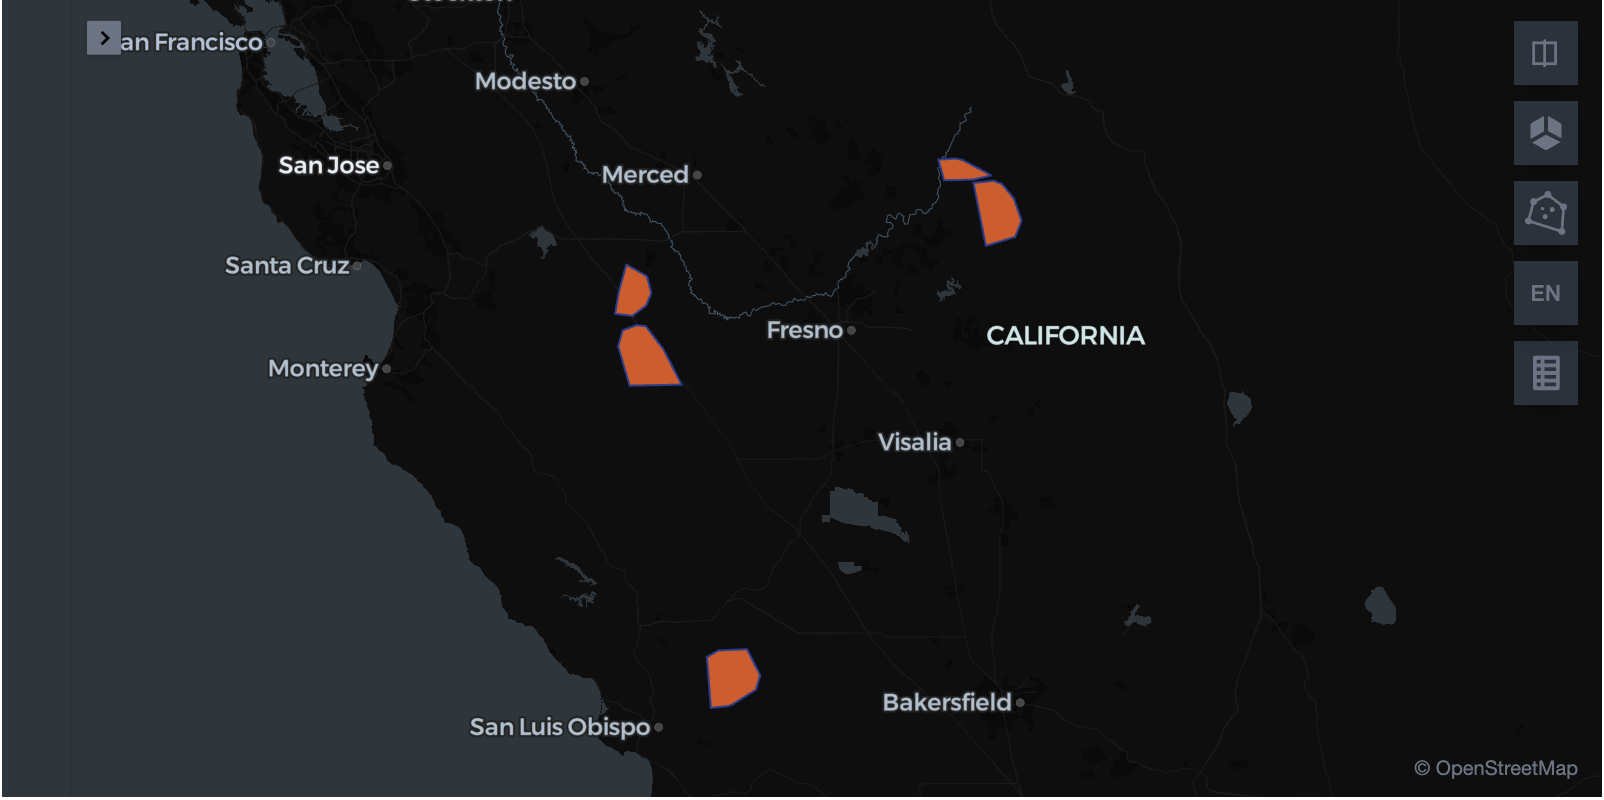

## ST_Isochrones Function Documentation

For detailed information on the `ST_Isochrones` function, refer to the official Wherobots documentation: [ST_Isochrones](https://docs.wherobots.com/latest/references/wherobotsdb/vector-data/Function/#st_isochrones)